In [1394]:
import pandas as pd
import missingno as msno
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, robust_scale

In [1395]:
import scipy.stats

In [1396]:
df=pd.read_csv("/home/ha-brek/Devia_AI/Data/data_assurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500



## Partie modélisation :


Dans vos variables explicatives Si les distributions ne sont pas normales, appliquer une transformation logarithmique.
Pensez à fixer le hasard grâce à seeds et des random states.
Étant donné que la variable à prédire est continue, c’est un problème de régression. Je vous conseille d’utiliser les algorithmes suivants : régression linéaire, Lasso, Ridge et ElasticNet. Sklearn dispose d’implémentation pour chacun de ses modèles. Comparer vos modèles à l'aide du R2 et du RMSE.
Si vous avez besoin d’effectuer du pré-traitement des données (standardisation, encodage des données catégorielles, etc.) Je te conseille de passer par un pipeline avec sklearn.
Analysez vos résultats avec une approche statistique grâce à ce cours : https://openclassrooms.com/fr/courses/4525326-realisez-des-modelisations-de-donnees-performantes
Étant donné que vous disposez de peu de variables vous pouvez essayer de booster vos résultats grâce à un PolynomialFeature.
Sélectionner vos hyperparamètres grâce à des GridSearchCV et RandomSearchCV.
Sélectionner votre modèle ayant les meilleurs résultats et interpréter vos résultats, par exemple : quels sont les variables les plus importantes pour votre modèle.



### Preparation de données : 

In [1397]:
from sklearn.pipeline import Pipeline,FeatureUnion,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [1398]:
X = df.drop(['charges'], axis=1)
y = df['charges']

In [1399]:
# Remplacer 'bmi' par le nom de votre colonne de BMI et 'df' par le nom de votre DataFrame
bmi = X['bmi']

# Définissez les bornes de chaque catégorie de BMI
bins = [0, 18.5, 25, 30, 35, 40, float('inf')]

# Utilisez la fonction 'cut' pour transformer les valeurs de BMI en catégories
bmi_categories = pd.cut(bmi, bins, labels=['Underweight', 'Normal weight', 'Overweight', 'Obese Class I', 'Obese Class II', 'Obese Class III'])

# Ajoutez la colonne de catégories de BMI à votre DataFrame
X['bmi'] = bmi_categories

In [1400]:
X["children"]=X["children"].replace({0:"zero",1:'one',2:'two',3:'three',4:'Four',5:'five'})


### Split data 

In [1401]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


### Modèle Dummy :

In [1402]:
dummy = DummyRegressor()
X_train.head()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-0.0009192486886582252

In [1403]:
cols_to_encode = [ "sex","smoker","bmi","children" ]
cols_to_norm = [ "age"]
preprocessor = ColumnTransformer(
    [('Encoder',  OneHotEncoder() , cols_to_encode),('scaler',  RobustScaler() , cols_to_norm)],
)

### LinearRegression

#### Sans polynomiale Feature 

0.7501388648431188
0.778552795022519
0.7379581332809644


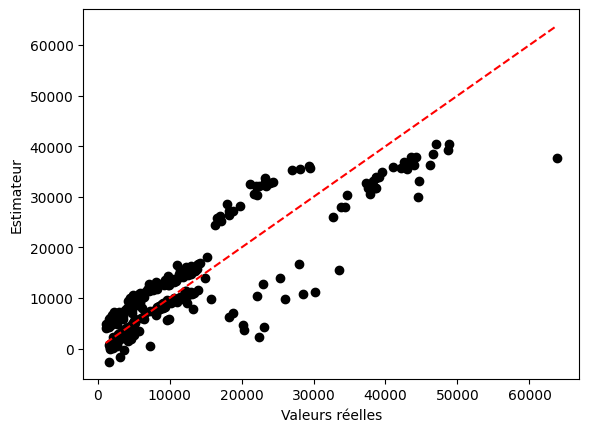

In [1404]:
model =make_pipeline(preprocessor, LinearRegression())
model.fit(X_train,y_train)

print(model.score(X_train,y_train))
print(model.score(X_test,y_test))
print(cross_val_score(model, X_train, y_train ).mean())

y_pred = model.predict(X_test)

# Tracer l'allure de l'estimateur et des données réelles
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Estimateur')
plt.show()

#### Avec Polynomiale Feature 

0.8463945310897665
0.8696092721947379
0.8849754187813448
0.8434854160079321


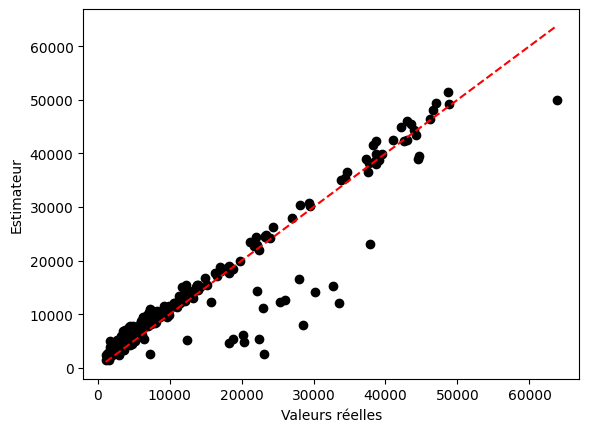

In [1405]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
  
model_linear = make_pipeline(preprocessor, PolynomialFeatures(),LinearRegression())
params = {
    'polynomialfeatures__degree':[1,2,3],
}

grid = GridSearchCV(model_linear, params, cv=6)
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.score(X_train,y_train))
print(grid.score(X_test,y_test))
print(cross_val_score(grid, X_train, y_train ).mean())

y_pred = grid.predict(X_test)

# Tracer l'allure de l'estimateur et des données réelles
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Estimateur')
plt.show()

#### Avec Residuals 

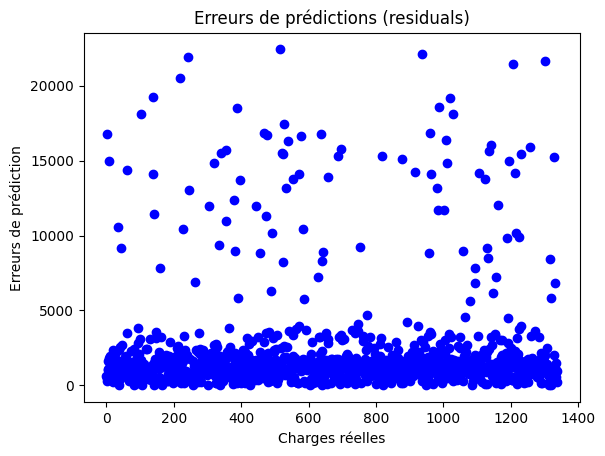

In [1406]:
y_pred = grid.predict(X_train)

residual =(y_pred-y_train).abs()

plt.scatter(y_train.index, residual, color="blue")
plt.title("Erreurs de prédictions (residuals)")
plt.xlabel("Charges réelles")
plt.ylabel("Erreurs de prédiction")
plt.show()
# Filter the residuals greater than 20000 


In [1407]:

residual_to_drop = residual[residual> 15000].index
X_train_new = X_train.drop(residual_to_drop)
y_train_new = y_train.drop(residual_to_drop)


0.9224490750621787
0.9384587163971274
0.886857600174778
0.9224490750621787


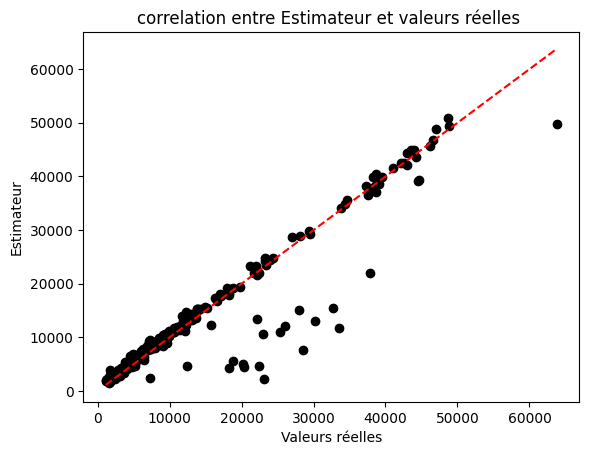

In [1408]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
  
model_linear = make_pipeline(preprocessor, PolynomialFeatures(),LinearRegression())
params = {
    'polynomialfeatures__degree':[1,2,3],
}

grid = GridSearchCV(model_linear, params, cv=5)
grid.fit(X_train_new, y_train_new)
print(grid.best_score_)
print(grid.score(X_train_new,y_train_new))
print(grid.score(X_test,y_test))
print(cross_val_score(grid, X_train_new, y_train_new ).mean())

y_pred = grid.predict(X_test)

# Tracer l'allure de l'estimateur et des données réelles
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Estimateur')
plt.title("correlation entre Estimateur et valeurs réelles ")
plt.show()


#### cook_distance

In [1409]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
  
model_linear = make_pipeline(preprocessor, PolynomialFeatures(),LinearRegression())
params = {
    'polynomialfeatures__degree':[1,2,3],
}

grid = GridSearchCV(model_linear, params, cv=5)
grid.fit(X_train_new, y_train_new)

y_pred = grid.predict(X_train_new)

#fit the model
model = OLS(y_train_new, y_pred).fit()

# get influence information
influence = model.get_influence()


# get the cook distance
cook_distance_ = influence.cooks_distance[0]
cook_distance_df = pd.DataFrame(cook_distance_, columns=['cook_distance'],index=X_train_new.index)
threshold = 4/X_train.shape[0]
threshold = 0.0001
#print(threshold)
cook_to_drop = cook_distance_df[cook_distance_df.cook_distance > threshold].index
cook_to_drop
X_train_cook = X_train_new.drop(cook_to_drop)
y_train_cook = y_train_new.drop(cook_to_drop)


0.9983862961879303
0.9984308322361907
0.8797950227056798


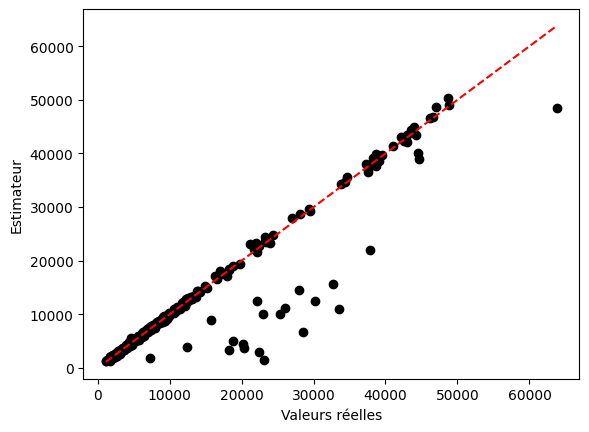

In [1410]:
#for threshold in np.linspace(0.00001,0.0001,10):

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

model_linear = make_pipeline(preprocessor, PolynomialFeatures(),LinearRegression())
params = {
    'polynomialfeatures__degree':[1,2,3],
}

grid = GridSearchCV(model_linear, params, cv=6)
grid.fit(X_train_cook, y_train_cook)
print(grid.best_score_)
print(cross_val_score(grid, X_train_cook, y_train_cook ).mean())
grid.fit(X_train_cook, y_train_cook)
print(grid.score(X_test, y_test))

y_pred = grid.predict(X_test)

# Tracer l'allure de l'estimateur et des données réelles
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Estimateur')
plt.show()


### ElasticNet :

0.4671952668755104
0.4775494941543168
0.45992116462598825


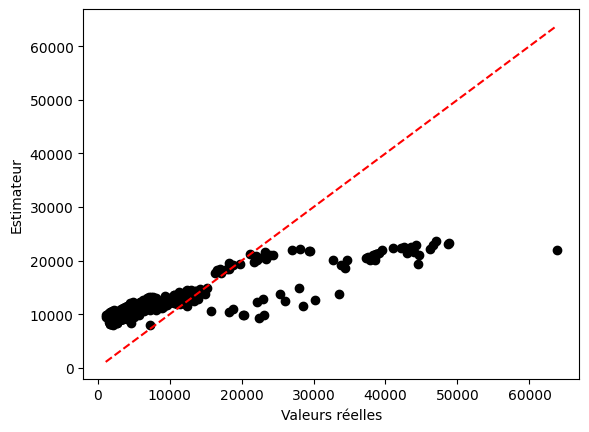

In [1411]:
from sklearn.linear_model import ElasticNet

model =make_pipeline(preprocessor, ElasticNet())
model.fit(X_train,y_train)
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))
print(cross_val_score(model, X_train, y_train ).mean())

y_pred = model.predict(X_test)

# Tracer l'allure de l'estimateur et des données réelles
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Estimateur')
plt.show()

#### Avec Polynomiales Feature 

{'elasticnet__alpha': 30, 'elasticnet__l1_ratio': 1, 'polynomialfeatures__degree': 2}
0.8537839497501787
0.8647939096584929
0.8862711692726009


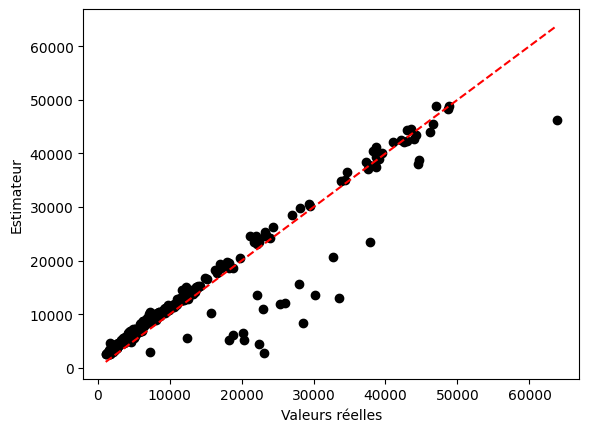

In [1412]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet


model_elasticnet = make_pipeline(preprocessor, PolynomialFeatures(),ElasticNet())
params = {
    'polynomialfeatures__degree':[1,2,3],
    'elasticnet__alpha':[30,30.5],
    'elasticnet__l1_ratio': [0.9,1]
}

grid = GridSearchCV(model_elasticnet, params, cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_train,y_train))
print(grid.score(X_test,y_test))

y_pred = grid.predict(X_test)

# Tracer l'allure de l'estimateur et des données réelles
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Estimateur')
plt.show()


### Residus :

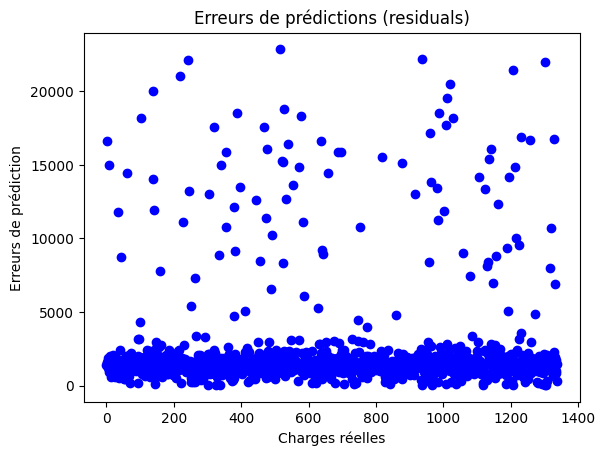

In [1413]:
y_pred = grid.predict(X_train)

residual =(y_pred-y_train).abs()

plt.scatter(y_train.index, residual, color="blue")
plt.title("Erreurs de prédictions (residuals)")
plt.xlabel("Charges réelles")
plt.ylabel("Erreurs de prédiction")
plt.show()
# Filter the residuals greater than 20000 
residual_to_drop = residual[residual> 20000].index
X_train_new = X_train.drop(residual_to_drop)
y_train_new = y_train.drop(residual_to_drop)


{'elasticnet__alpha': 16, 'elasticnet__l1_ratio': 1, 'polynomialfeatures__degree': 2}
0.8751551500511848
0.8876691982363784
0.8883080513646824


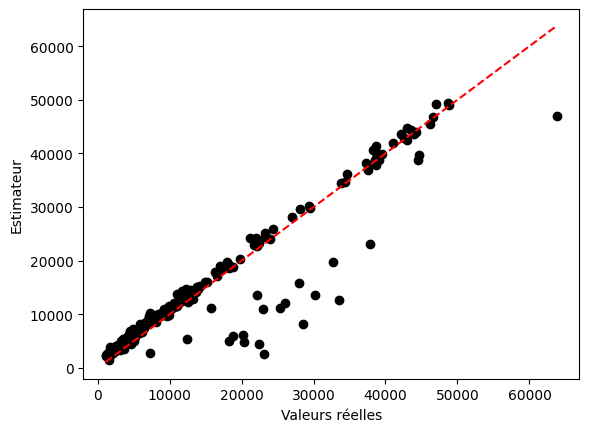

In [1414]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet


model_elasticnet = make_pipeline(preprocessor, PolynomialFeatures(),ElasticNet())
params = {
    'polynomialfeatures__degree':[1,2,3],
    'elasticnet__alpha':[14,15,16],
    'elasticnet__l1_ratio': [0.9,1]
}

grid = GridSearchCV(model_elasticnet, params, cv=5)
grid.fit(X_train_new, y_train_new)
print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_train_new,y_train_new))
print(grid.score(X_test,y_test))

y_pred = grid.predict(X_test)

# Tracer l'allure de l'estimateur et des données réelles
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Estimateur')
plt.show()

#### Avec Cook distance 

In [1415]:
model_Elastic = make_pipeline(preprocessor, PolynomialFeatures(),ElasticNet())
params = {
    'polynomialfeatures__degree':[1,2,3],
    'elasticnet__alpha':[0.9,1,1.1],
    'elasticnet__l1_ratio': [0.9,1]
}

grid = GridSearchCV(model_Elastic, params, cv=5)
grid.fit(X_train_new, y_train_new)

y_pred = grid.predict(X_train_new)

#fit the model
model = OLS(y_train_new, y_pred).fit()

# get influence information
influence = model.get_influence()


# get the cook distance
cook_distance_ = influence.cooks_distance[0]
cook_distance_df = pd.DataFrame(cook_distance_, columns=['cook_distance'],index=X_train_new.index)
threshold = 4/X_train.shape[0]
threshold = 0.0001
#print(threshold)
cook_to_drop = cook_distance_df[cook_distance_df.cook_distance > threshold].index
cook_to_drop
X_train_cook = X_train_new.drop(cook_to_drop)
y_train_cook = y_train_new.drop(cook_to_drop)

{'elasticnet__alpha': 0.9, 'elasticnet__l1_ratio': 1, 'polynomialfeatures__degree': 2}
0.9970369867383735
0.9972711598497133
0.8800334478790364


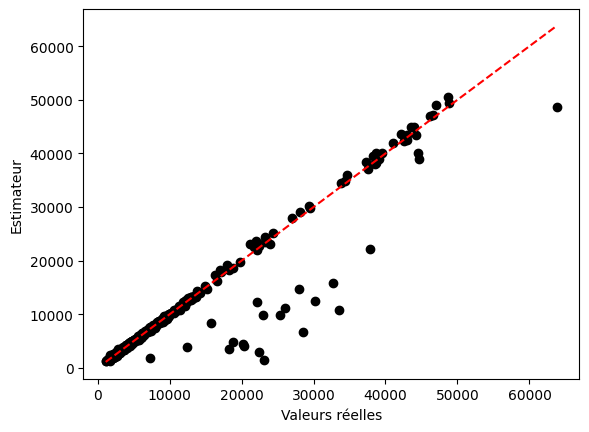

In [1416]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet


model_elasticnet = make_pipeline(preprocessor, PolynomialFeatures(),ElasticNet())
params = {
    'polynomialfeatures__degree':[1,2,3],
    'elasticnet__alpha':[0.9,1,1.1],
    'elasticnet__l1_ratio': [0.7,0.8,0.9,1]
}

grid = GridSearchCV(model_elasticnet, params, cv=5)
grid.fit(X_train_cook, y_train_cook)
print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_train_cook,y_train_cook))
print(grid.score(X_test,y_test))

y_pred = grid.predict(X_test)

# Tracer l'allure de l'estimateur et des données réelles
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Estimateur')
plt.show()

### modele de xgboost

0.9654747429826709
0.8282679252272489


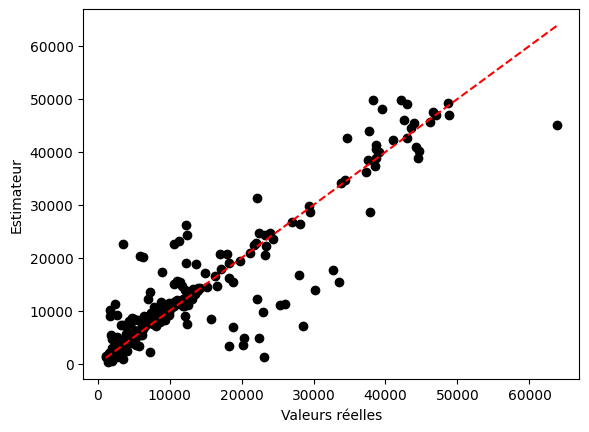

In [1417]:
import xgboost as xgb

model = make_pipeline(preprocessor, xgb.XGBRegressor())
# Entraîner le modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))
# Tracer l'allure de l'estimateur et des données réelles
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Estimateur')
plt.show()


### Avec Polynomiale feature 

{'polynomialfeatures__degree': 1, 'xgbregressor__learning_rate': 0.05000000000000001, 'xgbregressor__max_depth': 3}
0.8470276623384198
0.8715536493319189
0.8837878230910169


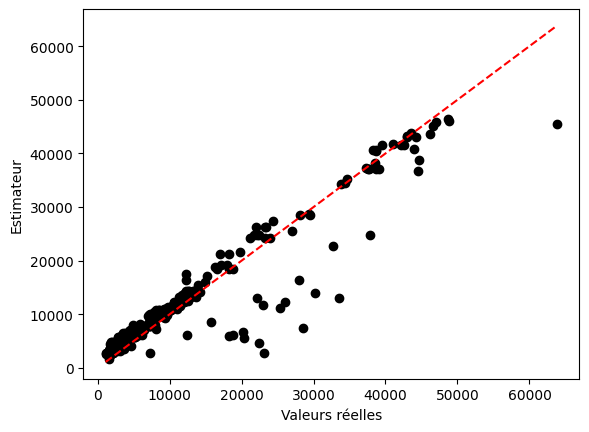

In [1418]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

model_elasticnet = make_pipeline(preprocessor, PolynomialFeatures(),xgb.XGBRegressor())
params = {
    'polynomialfeatures__degree':[1,2,3],
    'xgbregressor__learning_rate': np.linspace(0.01,0.1,10),
    'xgbregressor__max_depth': [2,3],
    #'xgbregressor__n_estimators': [150,190,240],
}
grid = GridSearchCV(model_elasticnet, params, cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_train,y_train))
print(grid.score(X_test,y_test))

y_pred = grid.predict(X_test)

# Tracer l'allure de l'estimateur et des données réelles
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Estimateur')
plt.show()


#cross_val_score(grid, X_train_new, y_train_new ).mean()

### Avec resudus

{'polynomialfeatures__degree': 1, 'xgbregressor__learning_rate': 0.06000000000000001, 'xgbregressor__max_depth': 3}
0.8701645722738485
0.8948089876834618
0.8869251657358015


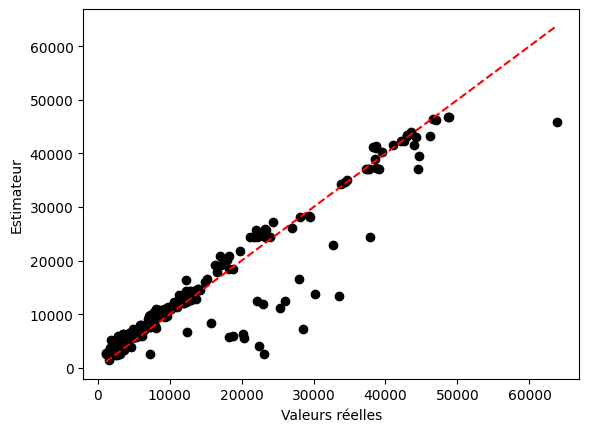

In [1419]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

model_elasticnet = make_pipeline(preprocessor, PolynomialFeatures(),xgb.XGBRegressor())
params = {
    'polynomialfeatures__degree':[1,2,3],
    'xgbregressor__learning_rate': np.linspace(0.01,0.1,10),
    'xgbregressor__max_depth': [2,3],
    #'xgbregressor__n_estimators': [150,190,240],
}
grid = GridSearchCV(model_elasticnet, params, cv=5)
grid.fit(X_train_new, y_train_new)
print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_train_new,y_train_new))
print(grid.score(X_test,y_test))

y_pred = grid.predict(X_test)

# Tracer l'allure de l'estimateur et des données réelles
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Estimateur')
plt.show()


#cross_val_score(grid, X_train_new, y_train_new ).mean()

### Distance de Cook

{'polynomialfeatures__degree': 2, 'xgbregressor__learning_rate': 0.8, 'xgbregressor__max_depth': 2}
0.992508366732466
0.999065960304811
0.8753407799560213


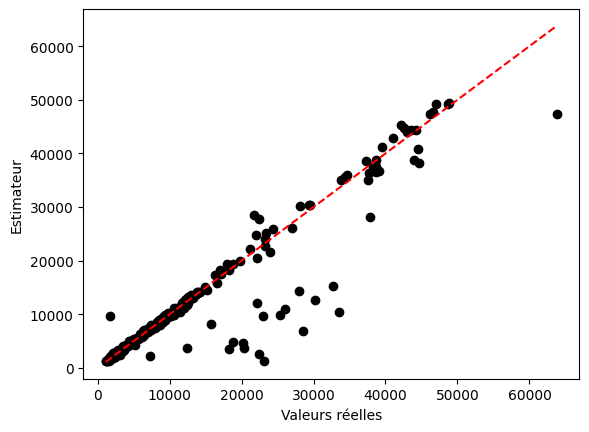

In [1420]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

model_elasticnet = make_pipeline(preprocessor, PolynomialFeatures(),xgb.XGBRegressor())
params = {
    'polynomialfeatures__degree':[1,2,3],
    'xgbregressor__learning_rate': np.linspace(0.01,0.8,10),
    'xgbregressor__max_depth': [2,3],
    #'xgbregressor__n_estimators': [150,190,240],
}
grid = GridSearchCV(model_elasticnet, params, cv=5)
grid.fit(X_train_cook, y_train_cook)
print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_train_cook,y_train_cook))
print(grid.score(X_test,y_test))

y_pred = grid.predict(X_test)

# Tracer l'allure de l'estimateur et des données réelles
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Estimateur')
plt.show()